# LSST Y10 ( No systematics marginalisation, No Super Sample Covariance)

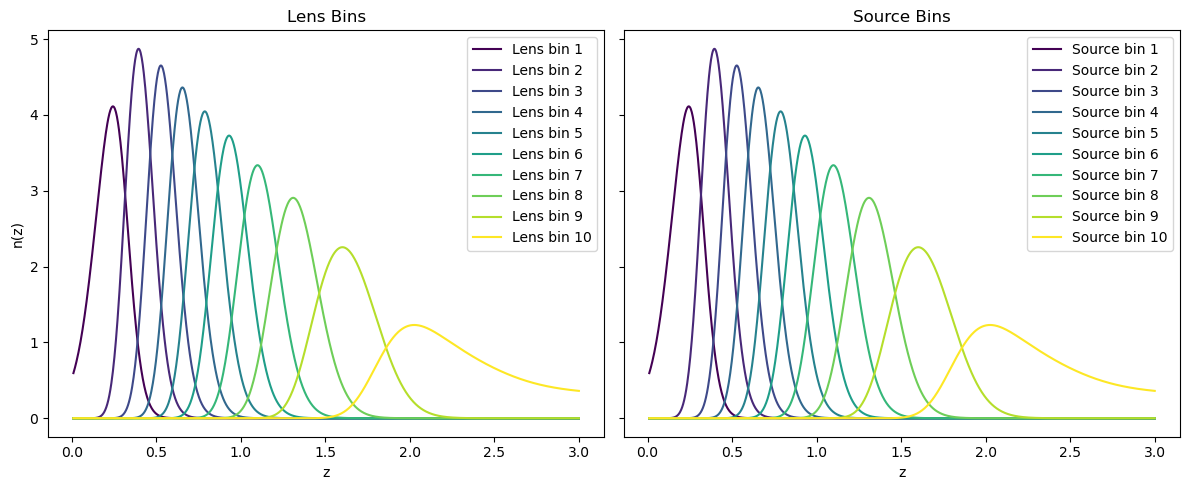

Omega_m  : 0.1120
h        : 0.2923
w0       : 0.2541
wa       : 1.0838
Removed no burn in


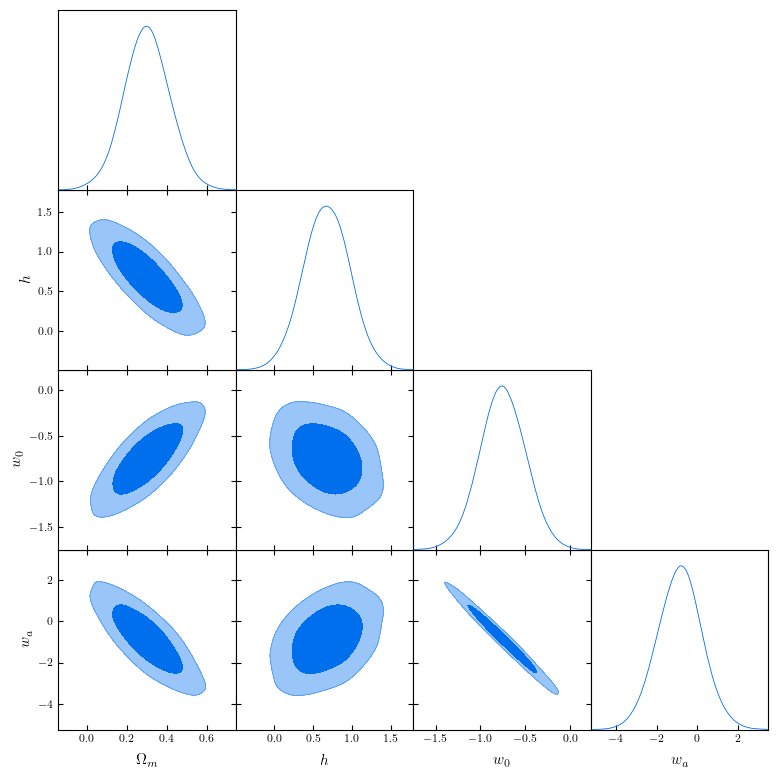

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
from shear_ratio import Forecast  # Adjusted import

# --- n(z) and binning utility ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)

def make_bins(nz_func, z, nbins):
    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)
    return np.exp(np.mean(np.log(ells)))

# --- Survey and cosmology settings ---
z = np.linspace(0.01, 3.0, 1000)
nz_lens = make_bins(parent_nz, z, 10)
nz_src = make_bins(parent_nz, z, 10)

ell_min, ell_max = 100, 2000
ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
area_deg2 = 14300
n_eff = 27.1
sigma_eps = 0.26
bias_lens = [1.4] * 10
fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

# --- Initialize forecast object ---
forecast = Forecast(
    nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=False,
    marginalize_delta_z_lens=False,
    marginalize_delta_z_src=False,
    delta_z_lens_prior_std=0.002,
    delta_z_src_prior_std=0.002,
    marginalize_multiplicative_bias=False,
    multiplicative_bias_prior_std=0.005
)

# --- Plot n(z) ---
forecast.plot_nz_bins()

# --- Cls and gk vector ---
cl_dict = forecast.compute_cls()
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)
gk_cov, _ = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=ell_max - ell_min)

# --- Monte Carlo covariance and Fisher matrix ---
R_cov, R_mean, ratio_labels = forecast.monte_carlo_shear_ratio_cov(gk_vector, gk_cov, gk_labels, nsamples=20000, seed=42)
param_dict = {k: fid_cosmo[k] for k in ["Omega_m", "h", "w0", "wa"]}
derivs, R_fid, _ = forecast.compute_shear_ratio_derivatives(cl_dict, gk_labels, param_dict)
Fisher, param_list = forecast.compute_shear_ratio_fisher(R_cov, derivs)

# Print parameter errors
errors = np.sqrt(np.diag(np.linalg.inv(Fisher)))
for p, err in zip(param_list, errors):
    print(f"{p:8s} : {err:.4f}")

# --- Draw and plot Fisher samples ---
samples, param_list_full = forecast.draw_fisher_samples(Fisher, param_list, truths=fid_cosmo, n_samples=5000)
forecast.plot_fisher_samples_with_getdist(samples, param_list_full, truths=fid_cosmo)

# Kinematic Lensing Like ( No systematics marginalisation, No Super Sample Covariance)
## Things actually get worse

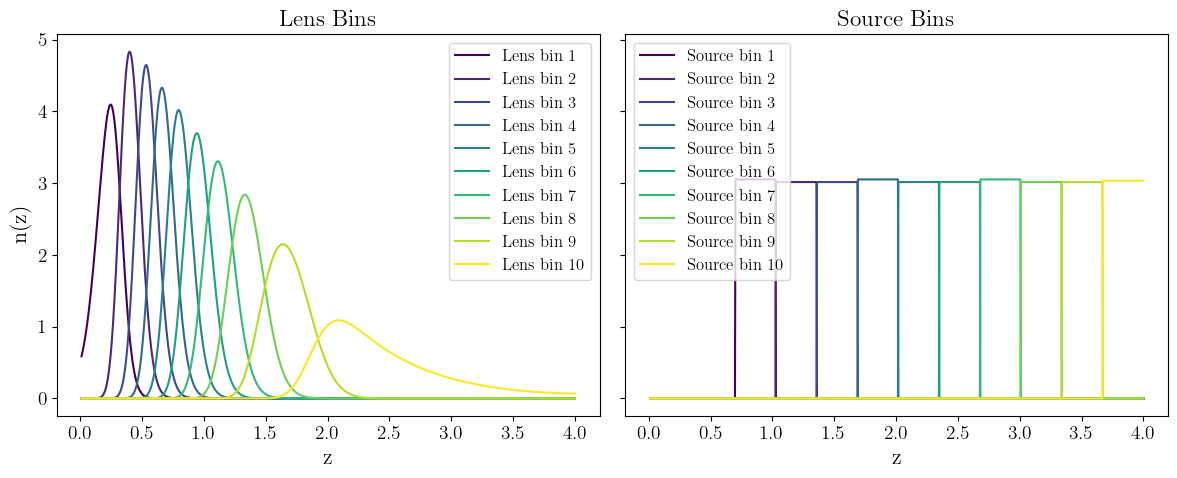

Removed no burn in


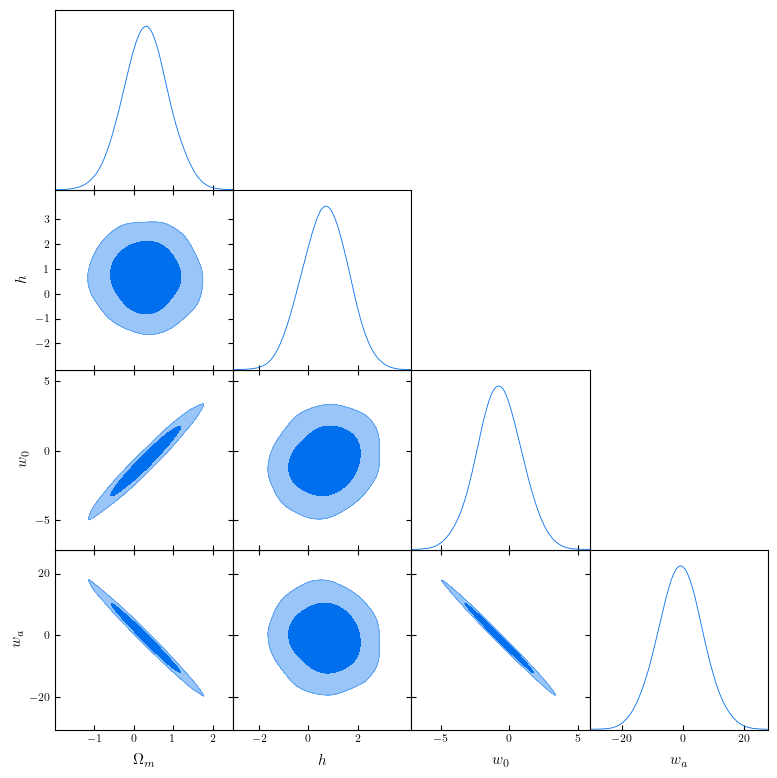

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from shear_ratio import Forecast  # assuming you saved your class as 'Forecast' in shear_ratio.py

# --- New Source n(z) Function: Tophat ---
def parent_nz_src(z):
    return np.where((z >= 0.7) & (z <= 4.), 1.0, 0.0)

# --- Original Lens n(z) Function (DES-like) ---
def parent_nz_lens(z):
    return z**2 * np.exp(-(z / 0.176)**0.783)

# --- Make bins utility ---
def make_bins(nz_func, z, nbins, smooth=True):
    nz = nz_func(z)
    nz /= np.trapz(nz, z)

    cdf = np.cumsum(nz)
    cdf /= cdf[-1]

    inv_cdf = np.interp(np.linspace(0, 1, nbins + 1), cdf, z)
    edges = inv_cdf

    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        nz_bin = np.zeros_like(z)
        nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)

        if smooth:
            smoothed = np.zeros_like(z)
            for j, zj in enumerate(z):
                kernel = np.exp(-0.5 * ((z - zj)/(0.05 * (1 + zj)))**2)
                kernel /= np.trapz(kernel, z)
                smoothed[j] = np.trapz(nz_bin * kernel, z)
            smoothed /= np.trapz(smoothed, z)
            bins.append((z.copy(), smoothed.copy()))
        else:
            bins.append((z.copy(), nz_bin.copy()))
    
    return bins

# --- Settings ---
z = np.linspace(0.01, 4.0, 1000)
nz_lens = make_bins(parent_nz_lens, z, nbins=10, smooth=True)
nz_src  = make_bins(parent_nz_src,  z, nbins=10, smooth=False)

# --- Survey and fiducial cosmology ---
def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)
    log_ell_mean = np.mean(np.log(ells))
    return np.exp(log_ell_mean)

ell_min = 100
ell_max = 2000
ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)

area_deg2 = 14300
n_eff = 27.1
sigma_eps = 0.26
bias_lens = [1.4] * 10

fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

# --- Initialize Forecast Class ---
forecast = Forecast(
    nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=False,
    marginalize_delta_z_lens=False,
    marginalize_delta_z_src=False,
    delta_z_lens_prior_std=0.002,
    delta_z_src_prior_std=0.002,
    marginalize_multiplicative_bias=False,
    multiplicative_bias_prior_std=0.005
)

# --- Plot n(z) bins ---
forecast.plot_nz_bins()

# --- Fisher Forecast Pipeline ---
cl_dict = forecast.compute_cls()
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)
gk_cov, _ = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=1900)

R_cov, R_mean, ratio_labels = forecast.monte_carlo_shear_ratio_cov(
    gk_vector, gk_cov, gk_labels, nsamples=20000, seed=42
)

param_dict = {k: fid_cosmo[k] for k in ["Omega_m", "h", "w0", "wa"]}
derivs, R_fid, _ = forecast.compute_shear_ratio_derivatives(cl_dict, gk_labels, param_dict)
Fisher, param_list = forecast.compute_shear_ratio_fisher(R_cov, derivs)

samples, param_list_full = forecast.draw_fisher_samples(Fisher, param_list, truths=fid_cosmo, n_samples=5000)

forecast.plot_fisher_samples_with_getdist(samples, param_list_full, truths=fid_cosmo)

# LSST Y10 More Bins (No Systematics Marg, No SSC)
## doesn't help

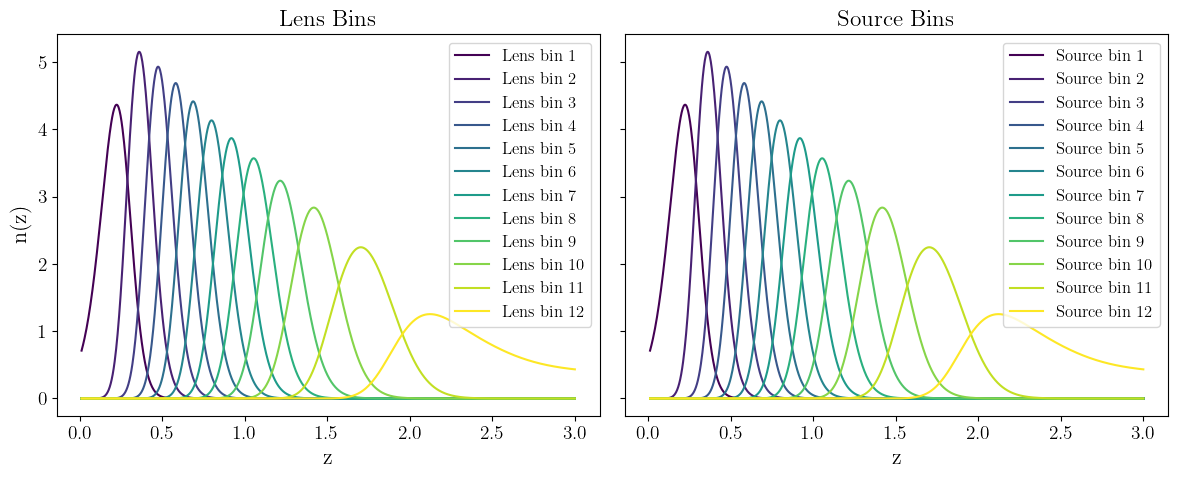

Omega_m  : 0.1066
h        : 0.2551
w0       : 0.2478
wa       : 1.0712
Removed no burn in


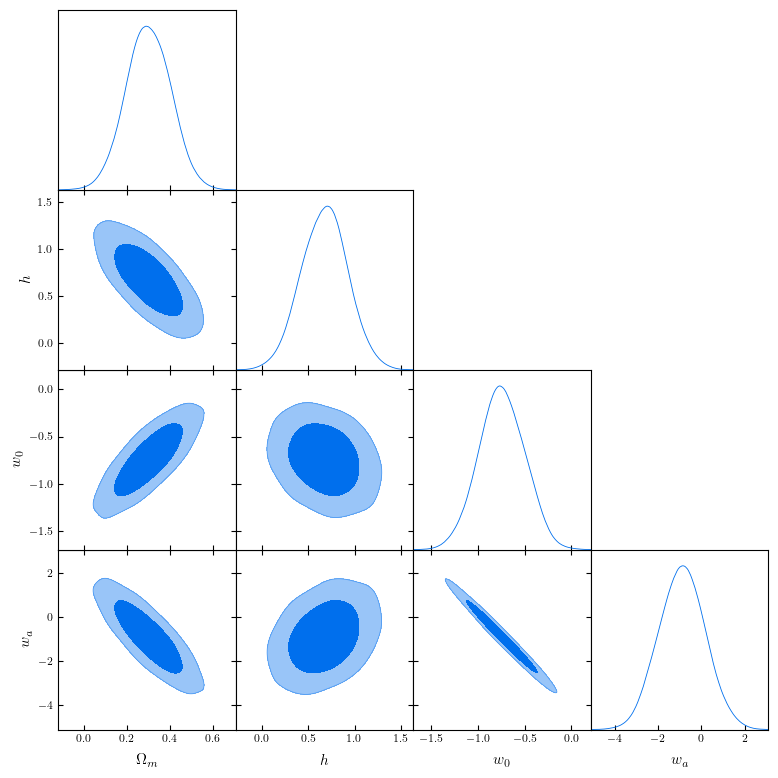

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
from shear_ratio import Forecast  # Adjusted import

# --- n(z) and binning utility ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)

def make_bins(nz_func, z, nbins):
    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)
    return np.exp(np.mean(np.log(ells)))

# --- Survey and cosmology settings ---
z = np.linspace(0.01, 3.0, 1000)
nz_lens = make_bins(parent_nz, z, 12)
nz_src = make_bins(parent_nz, z, 12)

ell_min, ell_max = 100, 2000
ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
area_deg2 = 14300
n_eff = 27.1
sigma_eps = 0.26
bias_lens = [1.4] * 12
fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

# --- Initialize forecast object ---
forecast = Forecast(
    nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=False,
    marginalize_delta_z_lens=False,
    marginalize_delta_z_src=False,
    delta_z_lens_prior_std=0.002,
    delta_z_src_prior_std=0.002,
    marginalize_multiplicative_bias=False,
    multiplicative_bias_prior_std=0.005
)

# --- Plot n(z) ---
forecast.plot_nz_bins()

# --- Cls and gk vector ---
cl_dict = forecast.compute_cls()
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)
gk_cov, _ = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=ell_max - ell_min)

# --- Monte Carlo covariance and Fisher matrix ---
R_cov, R_mean, ratio_labels = forecast.monte_carlo_shear_ratio_cov(gk_vector, gk_cov, gk_labels, nsamples=20000, seed=42)
param_dict = {k: fid_cosmo[k] for k in ["Omega_m", "h", "w0", "wa"]}
derivs, R_fid, _ = forecast.compute_shear_ratio_derivatives(cl_dict, gk_labels, param_dict)
Fisher, param_list = forecast.compute_shear_ratio_fisher(R_cov, derivs)

# Print parameter errors
errors = np.sqrt(np.diag(np.linalg.inv(Fisher)))
for p, err in zip(param_list, errors):
    print(f"{p:8s} : {err:.4f}")

# --- Draw and plot Fisher samples ---
samples, param_list_full = forecast.draw_fisher_samples(Fisher, param_list, truths=fid_cosmo, n_samples=5000)
forecast.plot_fisher_samples_with_getdist(samples, param_list_full, truths=fid_cosmo)

# LSST Y10 More Gals(No Systematics Marg, No SSC)
## this helps

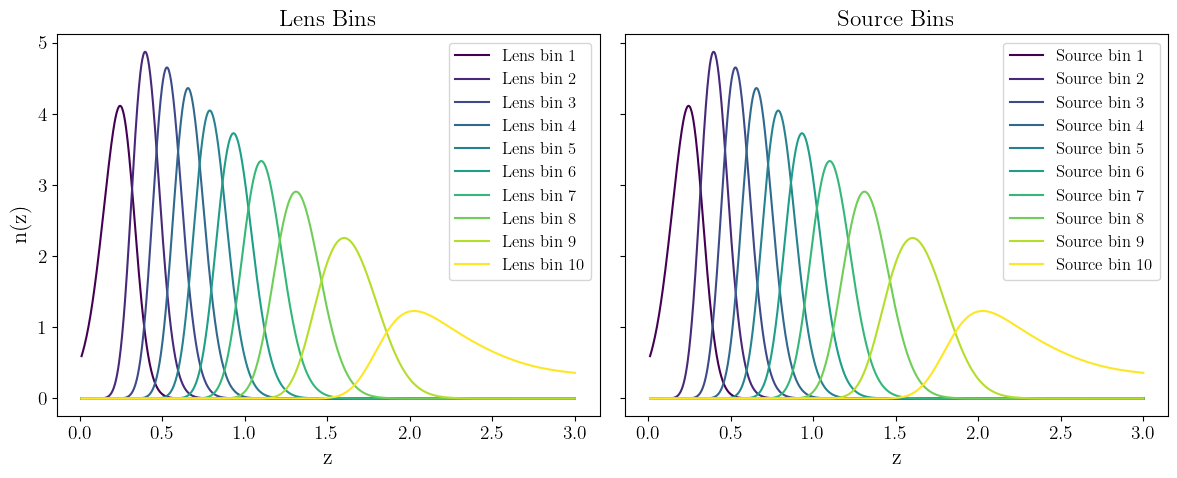

Omega_m  : 0.0500
h        : 0.1349
w0       : 0.1262
wa       : 0.5337
Removed no burn in


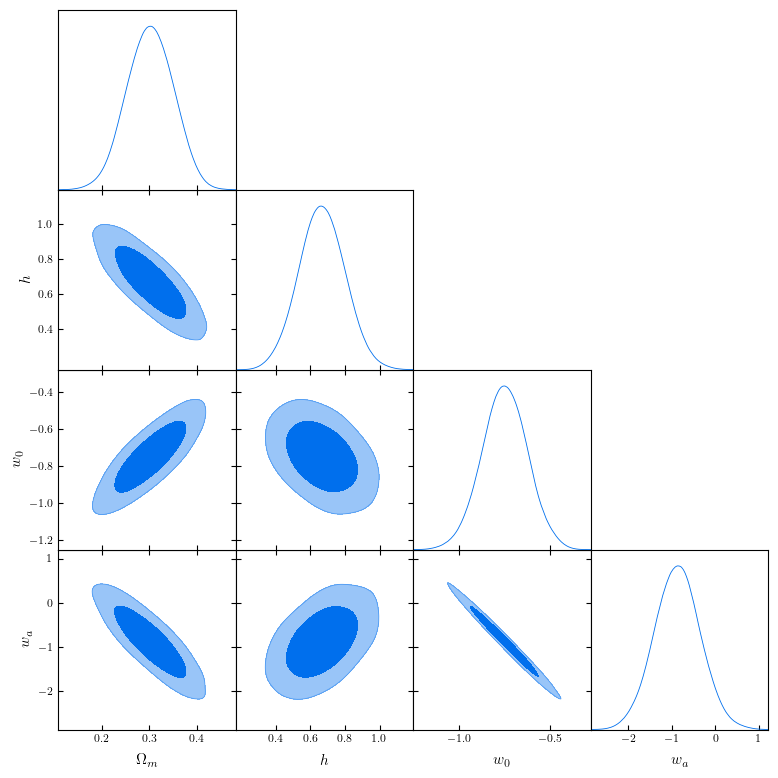

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
from shear_ratio import Forecast  # Adjusted import

# --- n(z) and binning utility ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)

def make_bins(nz_func, z, nbins):
    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)
    return np.exp(np.mean(np.log(ells)))

# --- Survey and cosmology settings ---
z = np.linspace(0.01, 3.0, 1000)
nz_lens = make_bins(parent_nz, z, 10)
nz_src = make_bins(parent_nz, z, 10)

ell_min, ell_max = 100, 2000
ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
area_deg2 = 14300
n_eff = 200
sigma_eps = 0.26
bias_lens = [1.4] * 10
fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

# --- Initialize forecast object ---
forecast = Forecast(
    nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=False,
    marginalize_delta_z_lens=False,
    marginalize_delta_z_src=False,
    delta_z_lens_prior_std=0.002,
    delta_z_src_prior_std=0.002,
    marginalize_multiplicative_bias=False,
    multiplicative_bias_prior_std=0.005
)

# --- Plot n(z) ---
forecast.plot_nz_bins()

# --- Cls and gk vector ---
cl_dict = forecast.compute_cls()
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)
gk_cov, _ = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=ell_max - ell_min)

# --- Monte Carlo covariance and Fisher matrix ---
R_cov, R_mean, ratio_labels = forecast.monte_carlo_shear_ratio_cov(gk_vector, gk_cov, gk_labels, nsamples=20000, seed=42)
param_dict = {k: fid_cosmo[k] for k in ["Omega_m", "h", "w0", "wa"]}
derivs, R_fid, _ = forecast.compute_shear_ratio_derivatives(cl_dict, gk_labels, param_dict)
Fisher, param_list = forecast.compute_shear_ratio_fisher(R_cov, derivs)

# Print parameter errors
errors = np.sqrt(np.diag(np.linalg.inv(Fisher)))
for p, err in zip(param_list, errors):
    print(f"{p:8s} : {err:.4f}")

# --- Draw and plot Fisher samples ---
samples, param_list_full = forecast.draw_fisher_samples(Fisher, param_list, truths=fid_cosmo, n_samples=5000)
forecast.plot_fisher_samples_with_getdist(samples, param_list_full, truths=fid_cosmo)

# LSST Y10 w/ systematics and Super Sample Covariance

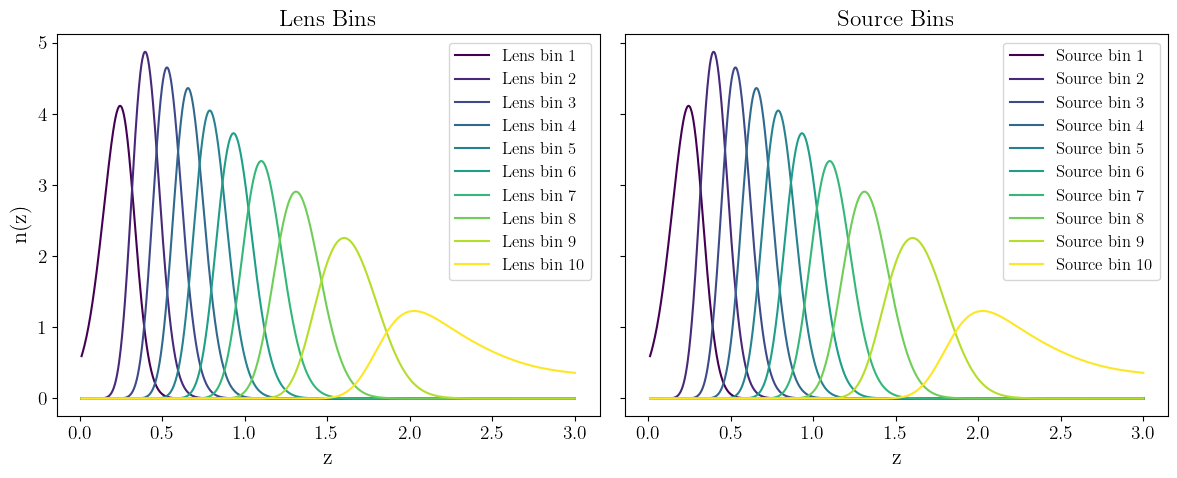

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
from shear_ratio import Forecast  # Adjusted import

# --- n(z) and binning utility ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)

def make_bins(nz_func, z, nbins):
    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)
    return np.exp(np.mean(np.log(ells)))

# --- Survey and cosmology settings ---
z = np.linspace(0.01, 3.0, 1000)
nz_lens = make_bins(parent_nz, z, 10)
nz_src = make_bins(parent_nz, z, 10)

ell_min, ell_max = 100, 2000
ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
area_deg2 = 14300
n_eff = 27.1
sigma_eps = 0.26
bias_lens = [1.4] * 10
fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

# --- Initialize forecast object ---
forecast = Forecast(
    nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=True,
    marginalize_delta_z_lens=True,
    marginalize_delta_z_src=True,
    delta_z_lens_prior_std=0.002,
    delta_z_src_prior_std=0.002,
    marginalize_multiplicative_bias=True,
    multiplicative_bias_prior_std=0.005
)

# --- Plot n(z) ---
forecast.plot_nz_bins()

# --- Cls and gk vector ---
cl_dict = forecast.compute_cls()
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)
gk_cov, _ = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=ell_max - ell_min)

# --- Monte Carlo covariance and Fisher matrix ---
R_cov, R_mean, ratio_labels = forecast.monte_carlo_shear_ratio_cov(gk_vector, gk_cov, gk_labels, nsamples=20000, seed=42)
param_dict = {k: fid_cosmo[k] for k in ["Omega_m", "h", "w0", "wa"]}
derivs, R_fid, _ = forecast.compute_shear_ratio_derivatives(cl_dict, gk_labels, param_dict)
Fisher, param_list = forecast.compute_shear_ratio_fisher(R_cov, derivs)

# Print parameter errors
errors = np.sqrt(np.diag(np.linalg.inv(Fisher)))
for p, err in zip(param_list, errors):
    print(f"{p:8s} : {err:.4f}")

# --- Draw and plot Fisher samples ---
samples, param_list_full = forecast.draw_fisher_samples(Fisher, param_list, truths=fid_cosmo, n_samples=5000)
forecast.plot_fisher_samples_with_getdist(samples, param_list_full, truths=fid_cosmo)